# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency
import geopandas as gpd
import seaborn as sns
import matplotlib.colors as mcolors

# Chi Square Test of Independence

In [33]:
# read in the data
vehicle = pd.read_csv('vehicle-2023.csv', index_col=0, low_memory = False)
collision = pd.read_csv('collision-2023.csv', index_col=0, low_memory = False)
casualty = pd.read_csv('casualty-2023.csv', index_col=0, low_memory = False)

# filter to include only London collisions on 20-30mph roads
collision = collision[(collision.police_force==1) | (collision.police_force==48)]
collision = collision[['accident_reference','longitude','latitude','accident_severity','number_of_vehicles','number_of_casualties',
                       'road_type','speed_limit','junction_detail','junction_control','pedestrian_crossing_human_control',
                       'pedestrian_crossing_physical_facilities','light_conditions','weather_conditions','road_surface_conditions',
                       'special_conditions_at_site','lsoa_of_accident_location']]

# fixing error in dataset
# if accident severity==1, enhanced_severity_collision=1
collision.loc[collision['accident_severity'] == 1, 'enhanced_severity_collision'] = 1

# filter to include only pedestrian casualties
casualty = casualty[casualty.casualty_class==3]

# filter collisions to only include collisions with pedestrian casualties
collision = collision[collision['accident_reference'].isin(casualty['accident_reference'])]

collision['accident_severity_binary'] = collision['accident_severity'].apply(
    lambda x: 'Serious/Fatal' if x in [1,2] else 'Slight'
)

# To do: filter independent variables
# speed limit: 20 or 30
collision = collision[collision.speed_limit < 35]
# only dual carriageways
collision = collision[collision.road_type == 6]
# junction control: filter out 0, -1, and 9
junction_control_df = collision[~collision.junction_control.isin([0,-1,9])]
# pedestrian crossing phys facs: filter out 9 and -1
pedestrian_crossing_df = collision[~collision.pedestrian_crossing_physical_facilities.isin([9,-1])]
# light conditions: filter out -1
light_conditions_df = collision[collision.light_conditions != -1]
# weather conditions: filter out 9 and -1
weather_conditions_df = collision[~collision.weather_conditions.isin([9,-1])]
# road surface conditions: filter out 9 and -1
road_surface_conditions_df = collision[~collision.road_surface_conditions.isin([9,-1])]
# road type: filter out 9 and -1
road_type_df = collision[~collision.road_type.isin([9,-1])]

/var/folders/rr/k04wzv7j0psdkxfsdqxwykn80000gn/T/ipykernel_37850/114307498.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labels.iloc[i, j] = f"{value:.2g}"  # Format to 2 significant digits
/var/folders/rr/k04wzv7j0psdkxfsdqxwykn80000gn/T/ipykernel_37850/114307498.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labels.iloc[i, j] = f"{value:.2g}"  # Format to 2 significant digits
/var/folders/rr/k04wzv7j0psdkxfsdqxwykn80000gn/T/ipykernel_37850/114307498.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible wit

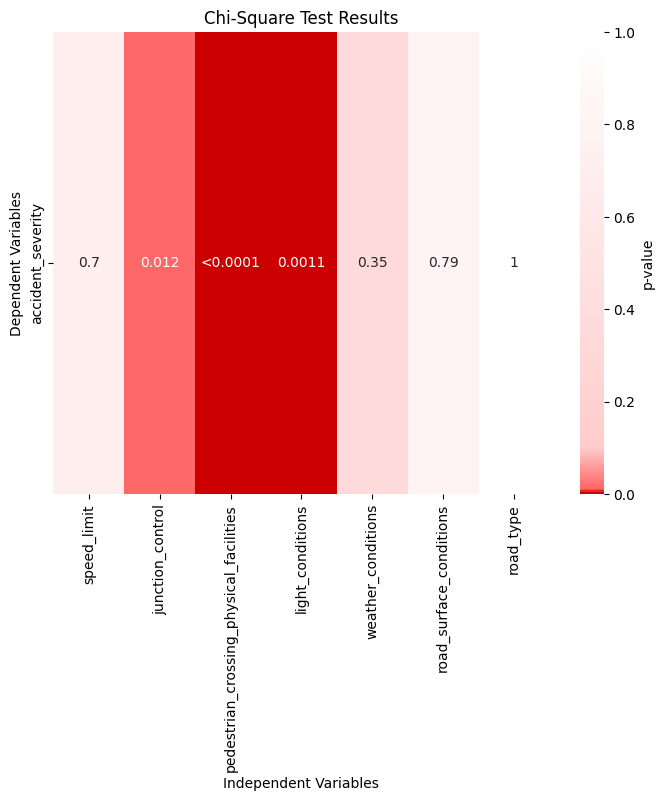

In [34]:
# Variables
independent_vars = ['speed_limit','junction_control',
                    'pedestrian_crossing_physical_facilities','light_conditions',
                    'weather_conditions','road_surface_conditions','road_type']
dependent_vars = ['accident_severity']

# Initialize an empty DataFrame to store p-values
results = pd.DataFrame(index=dependent_vars, columns=independent_vars)

# Perform Chi-Square tests
for dep in dependent_vars:
    for indep in independent_vars:
        # Create contingency table
        contingency_table = pd.crosstab(collision[indep], collision[dep])
        
        # Run Chi-Square test
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            results.loc[dep, indep] = p  # Store p-value
        except ValueError:  # Handle cases where contingency table is invalid
            results.loc[dep, indep] = np.nan

# Convert p-values to numeric
results = results.astype(float)

# Define the custom colormap
colors = [(0.8, 0, 0),(1, 0.4, 0.4),(1,0.8,0.8),(1, 1, 1)]  # Red to beige
nodes = [0.0, 0.01, 0.1, 1.0]  # Map 0.05 to 0.95 since nodes must span 0 to 1
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

# Create a custom annotation function
def annotate_labels(data):
    labels = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data.iloc[i, j]
            if value < 0.0001:
                labels.iloc[i, j] = "<0.0001"
            else:
                labels.iloc[i, j] = f"{value:.2g}"  # Format to 2 significant digits
    return labels

# Generate formatted labels
formatted_labels = annotate_labels(results)

# Create the heatmap with the custom annotations
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=formatted_labels, cmap=custom_cmap, fmt="", cbar_kws={'label': 'p-value'}, vmin=0, vmax=1)
plt.title('Chi-Square Test Results')
plt.xlabel('Independent Variables')
plt.ylabel('Dependent Variables')
plt.show()

In [24]:
# Create the contingency table
contingency_table = pd.crosstab(collision['road_type'], collision['accident_severity_binary'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared test statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

observed_expected = (contingency_table-expected)**2/expected

Chi-squared test statistic: 57.750944426449486
P-value: 3.540448034323631e-11
Degrees of freedom: 5
Expected frequencies:
 [[  26.59138533   67.40861467]
 [ 120.50989523  305.49010477]
 [ 136.35157159  345.64842841]
 [ 801.41909197 2031.58090803]
 [  32.81490105   83.18509895]
 [  97.31315483  246.68684517]]


# Ordinal logistic regression - how speed limit impacts collision severity in London

In [ ]:
# read in the data
vehicle = pd.read_csv('vehicle-2023.csv', index_col=0, low_memory = False)
collision = pd.read_csv('collision-2023.csv', index_col=0, low_memory = False)
casualty = pd.read_csv('casualty-2023.csv', index_col=0, low_memory = False)

# filter to include only London 
collision = collision[(collision.police_force==1) | (collision.police_force==48)]

# fixing error in dataset
# if accident severity==1, enhanced_severity_collision=1
collision.loc[collision['accident_severity'] == 1, 'enhanced_severity_collision'] = 1
collision = collision[collision['enhanced_severity_collision']!=-1]

# put severity categories in a sensible order
collision['enhanced_severity_collision_map'] = collision['enhanced_severity_collision'].map({3:1,7:2,6:3,5:4,1:5})

In [ ]:
# Define the dependent and independent variables
y = collision['enhanced_severity_collision_map']
X = collision[['speed_limit']]

# Fit the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Print the summary of the model
print(result.summary())

In [ ]:
# visualization
# Generate a range of speed limits for prediction
speed_limits = np.arange(collision['speed_limit'].min(), collision['speed_limit'].max() + 1)

# Create a DataFrame for prediction
predict_data = pd.DataFrame({'speed_limit': speed_limits})

# Predict probabilities for each speed limit
predicted_probs = result.predict(predict_data)
# predicted_probs.columns = ["Slight","Less Serious","Moderately Serious","Very Serious","Fatal"]

# Plot the probabilities
plt.figure(figsize=(10, 6))

color=['blue','green','yellow','orange','red']

severity_dict = {0:"Slight",1:"Less Serious",2:"Moderately Serious",3:"Very Serious",4:"Fatal"}

# Iterate through each severity level
for i, (severity_level,color) in enumerate(zip(predicted_probs.columns,color)):
    plt.plot(speed_limits, predicted_probs.iloc[:, i], label=f"Severity: {severity_dict[severity_level]}",color=color)

# Add plot labels and legend
plt.title("Predicted Probabilities of Accident Severity by Speed Limit")
plt.xlabel("Speed Limit (mph)")
plt.ylabel("Predicted Probability")
plt.legend(title="Accident Severity Levels")
plt.grid(True)
plt.show()

In [ ]:
# Predict the most likely category for each observation
predicted_probs = result.predict(X)
predicted_categories = np.argmax(predicted_probs.values, axis=1) + 1

# Create the confusion matrix
cm = confusion_matrix(y, predicted_categories, labels=[1,2,3,4,5])

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Slight", "LS", "MS", "VS", "Fatal"])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix for Ordinal Logistic Regression")
plt.show()

In [ ]:
mapping = {0:"Not at junction or within 20 metres",1:"Authorised person",2:"Auto traffic signal",3:"Stop sign",4:"Give way or uncontrolled",-1:"Data missing or out of range",9:"unknown (self reported)"}
collision.junction_control = collision.junction_control.map(mapping)

In [ ]:
collision.number_of_casualties.hist(bins=range(0,8))

In [ ]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(collision_numeric.corr(), fignum=f.number)
plt.xticks(range(collision_numeric.shape[1]), collision_numeric.columns, fontsize=14, rotation=90)
plt.yticks(range(collision_numeric.shape[1]), collision_numeric.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True)
collision.plot(kind='scatter', x='speed_limit', y='number_of_casualties', ax=axs[0], figsize=(16, 8))
collision.plot(kind='scatter', x='number_of_vehicles', y='number_of_casualties', ax=axs[1])
collision.plot(kind='scatter', x='accident_severity', y='number_of_casualties', ax=axs[2])